![logo](../img/LogoLine_horizon_C3S.png)

# <a id='page-top'></a> Calculation of global climatology of Earth Radiation Budget from EUMETSAT's CM SAF CLARA-A3 dataset

This notebook provides you with an introduction on EUMETSAT's CM SAF **CLARA-A3** dataset available at the [Climate Data Store](https://cds.climate.copernicus.eu/#!/home) (CDS). The dataset contains data for Essential Climate Variables (ECVs) _Earth Radiation Budget_, as well as _Cloud Properties and Surface Radiation Budget_, while this notebook focuses on **Earth Radiation Budget** as part of the ECV _Earth Radiation Budget_ available here: [Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview).

The notebook covers the full process from scratch and starts with a short introdution to the dataset and how to access the data from the Climate Data Store of the Copernicus Climate Change Service (C3S). This is followed by a step-by-step guide on how to process and visualize the data. Once you feel comfortable with the python code, you are invited to adjust or extend the code according to your interests. After a short introduction how to use a Jupyter notebook the analysis starts.<br>
Two figures below are results of Use Case 1 and 2, and the result of a successful run of the code.

![img](../img/erb-claraA3-banner.png)

The notebook has two main use cases with the following outline:


## Table of Contents

* [Introduction](#introduction)
* [Prerequisites and data acquisition](#data)
* [Use Cases](#usecases)
    * [Use case 1: The mean global Outgoing Longwave Radiation (OLR) radiation distribution](#uc1)
    * [Use case 2: The mean global Reflected Solar Flux (RSF) distribution](#uc2)
* [Get more information about Earth Radiation Budget](#references)

## <a id='introduction'></a> Introduction

This tutorial is about Earth radiation (top of atmosphere) parameters of EUMETSAT's CM SAF CLARA-A3 dataset. It covers step by step the process from retrieving the data to the processing and finally the visualisation of the results.

The CLARA-A3 dataset provides information of various Earth Radiation Budget (ERB) and Surface Radiation Budget (SRB) parameters as well as Cloud Properties parameters. Each ECV is covered by an own Jupyter Notebook (please also take a look at [CLARA-A3 SRB](https://ecmwf-projects.github.io/copernicus-training-c3s/intro.html) and [CLARA-A3 Clouds](https://ecmwf-projects.github.io/copernicus-training-c3s/intro.html)).

<div style="text-align: justify">In the following, we will concentrate on the earth radiation part. The CLARA-A3 dataset is the successor of CLARA-A2.1 and comprises almost 44 years (latest status: 09/2023) of continuous observations of radiation and clouds from space, thereby monitoring their spatial and temporal variability on Earth. Earth Radiation Budget parameters were not included in CLARA-A2.1<br> 
The CLARA-A3 radiation dataset contains all surface and Earth (top-of-the-atmosphere) fluxes, and thus, it enables studies of the full earth radiation budget.</div>

In the following, two examples are presented to illustrate some ideas on the usage, visualisation, and analysis of the CLARA-A3 earth radiation dataset.

### <a id='description'></a> Dataset description

Please find further information about the datasets as well as the data in the Climate Data Store sections "Overview", "Download data" and "Documentation": 

* Earth Radiation: Budget https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview
* Surface Radiation Budget: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-surface-radiation-budget?tab=overview
* Cloud Properties: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-cloud-properties?tab=overview


A [tutorial video](https://datastore.copernicus-climate.eu/documents/satellite-earth-radiation-budget/C3S2_312a_Lot1.4.0.3_202306_Tutorial_ECV_EarthRadiationBudget_final.mp4) describes the ECV _Earth Radiation Budget_ and its impact on the atmospheric conditions. In addition, it provides you with a small introduction of the satellite instruments and retrieval methods followed by general information about the dataset and support options provided by the CDS. 

## <a id='data'></a> Prerequisites and data acquisition

This tutorial is in the form of a Jupyter notebook. It can be run on a cloud environment, or on your own computer. You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://notebooks.gesis.org/binder/jupyter/user/ecmwf-projects--us-training-c3s-0vneba36/doc/tree/srb-claraA3.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/gh-pages/&#95;sources/srb-claraA3.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [1]:
!pip install cdsapi

/bin/bash: pip: Kommando nicht gefunden.


### Import libraries

The data have been stored in files written in NetCDF format. To best handle these, we will import the library [Xarray](http://xarray.pydata.org/en/stable/) which is specifically designed for manipulating multidimensional arrays in the field of geosciences. The libraries Matplotlib and Cartopy will also be imported for plotting and visualising the analysed data. We will also import the libraries [zipfile](https://docs.python.org/3/library/zipfile.html) to work with zip-archives, [OS](https://docs.python.org/3/library/os.html) to use OS-functions and pattern expansion, and [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

In [3]:
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np

# Library to work with zip-archives and OS-functions
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

### Download data using CDS API

This section is provides all necessary settings and input data to successfully run the use cases, and produce the figures. 

### Set up CDS API credentials

We will request data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/). In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [4]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '############'

Next, we specify a data directory in which we will download our data and all output files that we will generate. We will also create a directory, if it doesn't already exist.

In [5]:
DATADIR = './Data'
os.makedirs(DATADIR, exist_ok=True)

In advance of the following processing and visualisation part we set a directory where to save the figures. Default option is to save figures in the folder:

In [6]:
FIGPATH = '.'

### Search for data

To search for data, visit the [CDS website](https://cds.climate.copernicus.eu/).
Here we can search for "Earth Radiation Budget" or simply "ERB" data using the search bar. The data we need for this use case is the [Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview).
The Earth Radiation Budget (ERB) comprises the quantification of the reflected radiation from the Sun and the emitted longwave radiation from  Earth. This catalogue entry comprises data from a number of sources.

Once you reached the landing page, feel free to have a look at the documentation and information provided.

The data can be found in the "Download data"-tab with a form to select certain variables, years etc. For our use case we select as follows:

* Product family: `CLARA-A3 (CM SAF cLoud, Albedo and surface RAdiation dataset from AVHRR data)`
* Origin: `EUMETSAT (European Organisation for the Exploitation of Meteorological Satellites)`
* Variable: `Outgoing longwave radiation (Outgoing LW)`, `Outgoing shortwave radiation (Outgoing SW)`
* Climate data record type: `Thematic Climate Data Record (TCDR)`
* Time aggregation: `Monthly mean`
* Year: `Every year from 1979-2020 (shortcut with "Select all" at the bottom right)`
* Month: `Every month from January to December (shortcut with "Select all" at the bottom right)`
* Geographical area: `Whole available region`
* Format: `Zip file (.zip)`

Please make sure all **Terms of use** are accepted. This can be done at the bottom of the **Download data** tab.

At the bottom left of the page, click on **Show API request** and copy & paste the text into the Jupyter notebook. The first line can be skipped since it is already part of the **Import libraries** section.

Note: The download may take a few minutes. Feel free to have a look at the various information on the Earth Radiation Budget page in the CDS or already get familiar with the next steps.

In [6]:
c = cdsapi.Client(url=URL,key=KEY)

c.retrieve(
    'satellite-earth-radiation-budget',
    {
        'format': 'zip',
        'product_family': 'clara_a3',
        'origin': 'eumetsat',
        'variable': [
            'outgoing_longwave_radiation', 'outgoing_shortwave_radiation',
        ],
        'climate_data_record_type': 'thematic_climate_data_record',
        'time_aggregation': 'monthly_mean',
        'year': ['%04d' % (year) for year in range(1979, 2021)],
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    },
    f'{DATADIR}/download_claraA3_erb.zip',
)

2024-11-12 12:19:14,143 INFO [2024-01-09T00:00:00] NOAA/NCEI HIRS OLR was reprocessed from 2007 till 2023. Please see the Known issues section under the Documentation tab for more details.
2024-11-12 12:19:14,146 WARNING [2024-11-12T11:19:14.088967] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-11-12 12:19:14,148 INFO Request ID is f9bb767b-13cb-4f2c-955b-c4c860eee949
2024-11-12 12:19:14,419 INFO status has been updated to accepted
2024-11-12 12:19:27,130 INFO status has been updated to running
2024-11-12 12:27:41,929 INFO status has been updated to successful


332d742b6906f6560b70e0726ef33157.zip:   0%|          | 0.00/1.60G [00:00<?, ?B/s]

'./Data/download_claraA3_erb.zip'

The zip-file should be downloaded and saved at the correct place, that we have defined earlier. The zip archive containing one variable for monthly mean needs several GB of storage space.

The following lines unzip the data. **DATADIR + '/download_claraA3_erb.zip** is the path to the zip-file. The first line constructs a ZipFile() object, the second line applies the function **extractall** to extract the content.

DATADIR/'_ is the path we want to store the files.

In [7]:
with zipfile.ZipFile(DATADIR + '/download_claraA3_erb.zip', 'r') as zip_ref:
    zip_ref.extractall(DATADIR)

With the zip-file unziped and files at the right place we can start reading and processing the data.

<a id='load'></a> 
### Load dataset

The following line starting with "file" considers only files in the given directory starting the "OLRmm", "RSFmm" and ending with ".nc" and creates a list with all matching files. The "*" means "everything" and takes every file into account. This is quite useful since year and month are part of the file names. 

The second line reads the defined file list with the xarray function "open_mfdataset" (mf - multiple file) and concatenates them according to the time dimension.

In [8]:
file_olr = DATADIR + '/OLRmm*.nc'
file_rsf = DATADIR + '/RSFmm*.nc'

dataset_olr = xr.open_mfdataset(file_olr, concat_dim='time', combine='nested')
dataset_rsf = xr.open_mfdataset(file_rsf, concat_dim='time', combine='nested')

Please find below the xarray dataset of the Earth Radiation Budget exemplary:

It provides information about the:
- Dimensions: Lat and Lon with 0.25°x0.25° resolution and a lenght of 720/1440 and 504 months (42 years * 12 months)
- Coordinates: Spatial coordinates for Latitude and Longitude, temporal coordinates for time
- Data variables: List of different variables (in our case "LW_flux" and "SW_flux" are relevant)
- Attributes: Various important information about the dataset

In [9]:
dataset_olr

<xarray.Dataset> Size: 10GB
Dimensions:                   (time: 504, lat: 720, bnds: 2, lon: 1440)
Coordinates:
  * lon                       (lon) float64 12kB -179.9 -179.6 ... 179.6 179.9
  * lat                       (lat) float64 6kB -89.88 -89.62 ... 89.62 89.88
  * time                      (time) datetime64[ns] 4kB 1979-01-01 ... 2020-1...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds                  (time, lat, bnds) float64 6MB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds                  (time, lon, bnds) float64 12MB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    time_bnds                 (time, bnds) datetime64[ns] 8kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    record_status             (time) uint8 504B dask.array<chunksize=(1,), meta=np.ndarray>
    number_of_lw_daily_means  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    LW_flux                   (time, lat, lon) float64 4GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    number_of_lw_inst_obs     (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    bitflags_lw               (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/38)
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    title:                      CM SAF Cloud, Albedo and Radiation dataset, A...
    summary:                    This file contains AVHRR-based Thematic Clima...
    ...                         ...
    variable_id:                LW_flux
    license:                    The CM SAF data are owned by EUMETSAT and are...
    source:                     FCDR AVHRR-GAC : ERA-5 : OSISAF : USGS : IGBP
    lineage:                    pygac/gac2pps.py : NWC/PPS version v2018 : CL...
    CMSAF_L2_processor:         CLARA-A3 TOA toa_flux v2.0
    CMSAF_L3_processor:         CLARA-A3 TOA dailymean v2.4

## <a id='usecases'></a> Use Cases

## <a id='uc1'></a> Use case 1: The mean global Outgoing Longwave Radiation (OLR) radiation distribution

Use Case #1 aims to give an overview about the OLR distribution. We do that by plotting the global mean OLR from the CLARA-A3 dataset. Please note that we need to open the dataset to be able to execute this usecase, as described in the previous section ["Load dataset"](#load).

#### <a id='calculation_1'></a> Calculation of the temporal average of OLR

We calculate the temporal average with the function np.nanmean. np is common alias for numpy and a library for mathmatical working with arrays. nanmean averages the data and ignores nan's. This operation is applied to "dataset_olr" and the variable Outgoing Longwave Radiation or "LW_flux". axis=0 averages over the first axis, which is "time" in this case. This leads to a two-dimensional result with an average over time.

In [10]:
# Calculate temporal average
average = np.nanmean(dataset_olr['LW_flux'], axis=0)

# Get longitude and latitude coordinates. Both are variables of the dataset and available with
# the ".variables['lat/lon']" function; [:] usually means ["from":"till"] but
# without numbers it means "everything"
lon = dataset_olr.variables['lon'][:]
lat = dataset_olr.variables['lat'][:]

: 

#### <a id='plot_1'></a> Plot of the temporal average of OLR

With the calculation done the data is ready for a plot. Please find the plot and settings in the next section.

Some further notes:
- Matplotlib provides a wide range of colorbars: https://matplotlib.org/stable/users/explain/colors/colormaps.html; the addition <em>_r</em> reverses the colorbar
- The "add_subplot" part provides the option to plot more than one figure (e.g. a 2x2 matrix with four plots together). In this case (1,1,1) means that the panel is a 1x1 matrix and the following plot is the first subplot.

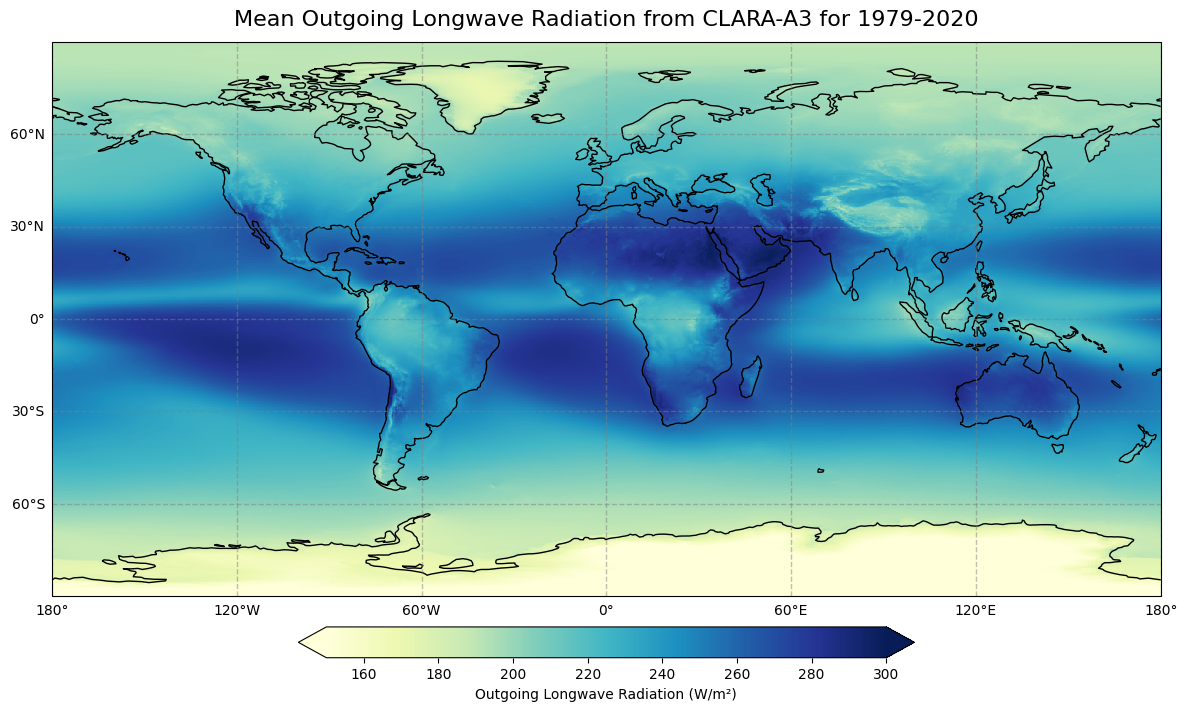

In [11]:
# Create figure and size
fig = plt.figure(figsize=(15, 8))

# Create the figure panel and define the Cartopy map projection (PlateCarree)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the data and set colorbar, minimum and maximum values
im = plt.pcolormesh(lon, lat, average, cmap='YlGnBu', vmin=150, vmax=300)

# Set title and size
ax.set_title('Mean Outgoing Longwave Radiation from CLARA-A3 for 1979-2020', fontsize=16, pad=12)

# Define gridlines with linewidth, color, opacity and style
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Set coastlines
ax.coastlines()

# Set colorbar and adjust size, location and text
cbar = plt.colorbar(im, fraction=0.05, pad=0.05, orientation='horizontal', extend='both')
cbar.set_label('Outgoing Longwave Radiation (W/m²)')

# Save figure in defined path and name
plt.savefig(FIGPATH + '/OLRmm_mean.png')

# Show plot and close it afterwards to reduce the amount of storage
plt.show()
plt.close()

**Figure 1** shows the global mean values of the Outgoing Longwave Radiation (OLR).

## <a id='uc2'></a> Use case 2: The mean global Reflected Solar Flux (RSF) distribution

Use Case #2 aims to give an overview about the RSF distribution. We do that by plotting the global mean RSF from the CLARA-A3 dataset. Please note that we need to open the dataset to be able to execute this usecase, as described in the previous section ["Load dataset"](#load).

#### <a id='calculation_2'></a> Calculation of the temporal average of RSF

We calculate the temporal average with the function np.nanmean. np is common alias for numpy and a library for mathmatical working with arrays. nanmean averages the data and ignores nan's. This operation is applied to "dataset_olr" and the variable Reflected Solar Flux or "SW_flux". axis=0 averages over the first axis, which is "time" in this case. This leads to a two-dimensional result with an average over time.

In [12]:
# Calculate temporal average
average = np.nanmean(dataset_rsf['SW_flux'], axis=0)

# Get longitude and latitude coordinates. Both are variables of the dataset and available with
# the ".variables['lat/lon']" function; [:] usually means ["from":"till"] but
# without numbers it means "everything"
lon = dataset_rsf.variables['lon'][:]
lat = dataset_rsf.variables['lat'][:]

#### <a id='plot_2'></a> Plot of the temporal average of RSF

With the calculation done the data is ready for a plot. Please find the plot and settings in the next section.


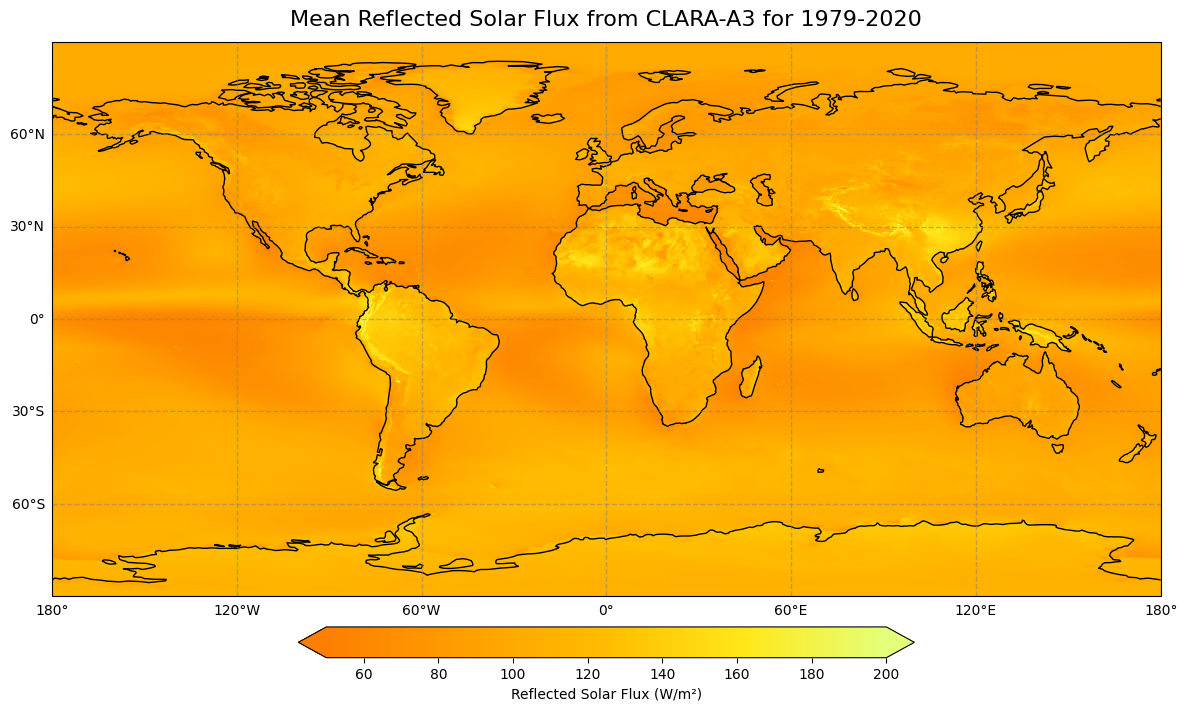

In [13]:
# Create figure and size
fig = plt.figure(figsize=(15, 8))

# Create the figure panel and define the Cartopy map projection (PlateCarree)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the data and set colorbar, minimum and maximum values
im = plt.pcolormesh(lon, lat, average, cmap='Wistia_r', vmin=50, vmax=200)

# Set title and size
ax.set_title('Mean Reflected Solar Flux from CLARA-A3 for 1979-2020', fontsize=16, pad=12)

# Define gridlines with linewidth, color, opacity and style
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Set coastlines
ax.coastlines()

# Set colorbar and adjust size, location and text
cbar = plt.colorbar(im, fraction=0.05, pad=0.05, orientation='horizontal', extend='both')
cbar.set_label('Reflected Solar Flux (W/m²)')

# Save figure in defined path and name
plt.savefig(FIGPATH + '/RSFmm_mean.png')

# Show plot and close it afterwards to reduce the amount of storage
plt.show()
plt.close()

**Figure 2** shows the global mean values of the Reflected Solar Flux (RSF).

## <a id='references'></a> Get more information about Earth Radiation Budget

- [About Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)